In [2]:
# inspecting the quality of the IF in higher dimensions.
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [4]:
# function definitions.
def simulate_gaussian_data(n, p, noise_std=1.0):
    """
    Simulate multivariate Gaussian dataset and a response vector 
    according to a standard Gaussian linear model.
    """
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=np.eye(p), size=n) # X ~ MVN(0, I_p)
    # true_coefficients = np.random.randn(p) # coeff ~ No(0, 1)
    true_coefficients = np.random.uniform(-1, 1, p) # coeff ~ unif(-1, 1)
    y = X @ true_coefficients + np.random.normal(0, noise_std, n) # e ~ N(0, noise_std^2)
    return X, y, true_coefficients

def compute_influence_function_old(X, y, index): # non-vectorized version.
    """
    X (NDArray): [n, p]; data matrix.
    y (Array): [n]; response variable.
    index (int): index of the dropped point.
    Output (Array): [p]; the influence function approximation for the point at index.
    """
    # Fit the model to the full dataset
    model1 = LinearRegression(fit_intercept=False)
    model1.fit(X, y)
    
    # Coefficients from the full model
    beta_full = model1.coef_
    
    # Compute the gradient of the loss function w.r.t the parameters
    residuals = y - model1.predict(X)
    gradient = X[index] * residuals[index]
    hessian = np.linalg.inv(X.T @ X)

    # Influence function approximation to dropping a data point.
    return beta_full - (hessian @ gradient)

def compute_influence_function(X, y, model): # vectorized version.
    """
    X (NDArray): [n, p]; data matrix.
    y (Array): [n]; response variable.
    Output (Array): [n, p]; the influence function approximation for each point in the dataset.
    """
    # Coefficients from the full model
    beta_full = model.coef_
    # Compute the hession*gradient of the loss function w.r.t \theta.
    residuals = y - model.predict(X)
    XtX = X.T @ X # [P, P]
    XtXinvX = np.linalg.solve(XtX, X.T)  # [P, N]
    XtXinvX * residuals.T # [P, N]
    # Influence function approximation to dropping a data point.
    beta_full = beta_full[:, np.newaxis]
    if_approx = beta_full - (XtXinvX * residuals.T)
    return if_approx.T

def compute_dfbeta_old(X, y, index): # non-vectorized version.
    """
    X (NDArray): [n, p]; data matrix.
    y (Array): [n]; response variable.
    index (int): index of the dropped point.
    Output (Array): [p]; the refit after dropping the point at position index.
    """
    # Fit the model to the full dataset
    model1 = LinearRegression(fit_intercept=False)
    model1.fit(X, y)
    
    # Coefficients from the full model
    beta_full = model1.coef_
    
    # Compute the gradient of the loss function w.r.t the parameters
    residuals = y - model1.predict(X)
    gradient = X[index] * residuals[index]
    hessian = np.linalg.inv(X.T @ X)
    leverage = X[index] @ np.linalg.inv(X.T @ X) @ X[index]
    change = (hessian @ gradient) / (1 - leverage)

    # Influence function approximation to dropping a data point.
    return beta_full - change

def compute_dfbeta(X, y, model): # vectorized version.
    '''
    X (NDArray): [n, p]; data matrix.
    y (Array): [n]; response variable.
    index (int): index of the dropped point.
    Output (Array): [n, p]; the refits for all n data points.
    '''
    # Coefficients from the full model
    beta_full = model.coef_
    # Compute the hession*gradient of the loss function w.r.t \theta.
    residuals = y - model.predict(X)
    leverage_mat = X @ (np.linalg.inv(X.T @ X)) @ X.T
    diag_leverage = np.diag(1 / (1 - np.diag(leverage_mat))) # 1/(1-h_ii)
    diag_leverage @ residuals # [N, 1]
    
    XtX = X.T @ X # [P, P]
    XtXinvX = np.linalg.solve(XtX, X.T)  # [P, N]
    XtXinvX * (diag_leverage @ residuals).T # [P, N]
    # Influence function approximation to dropping a data point.
    beta_full = beta_full[:, np.newaxis]
    refit_approx = beta_full - (XtXinvX * (diag_leverage @ residuals).T)
    return refit_approx.T

def compute_IF_and_refits_smw(X, y):
    """
    X (NDArray): [n, p]; data matrix.
    y (Array): [n]; response variable.
    Output (Array): 
    - [n, p]; the influence function approximation for each dropped point.
    - [n, p]; the refit coefficients for each dropped point.
    - [p]; the coefficients from the model fit to full data.
    """
    n = X.shape[0]
    p = X.shape[1]

    model_full = LinearRegression(fit_intercept=False)
    model_full_fit = model_full.fit(X, y)
    model_full_coef = model_full_fit.coef_

    # Compute the eigenvalues of X^T * X
    XtX = np.dot(X.T, X)
    eigenvalues_XtX = np.linalg.eigvals(XtX)

    influence_functions = compute_influence_function(X, y, model_full)
    refit_coefficients = compute_dfbeta(X, y, model_full)

    return influence_functions, refit_coefficients, model_full_coef, eigenvalues_XtX

In [5]:
# unit testing. dfbeta implemented correctly.
n=10
p=2
index = 6
testX, testy, testcoeff = simulate_gaussian_data(n, p, noise_std=1.0)
dfbeta = compute_dfbeta_old(testX, testy, index)
print("dfbeta: ", dfbeta)

# refit the model without the ith data point.
deleted_i_X = np.delete(testX, index, axis=0)
deleted_i_y = np.delete(testy, index)
model_d = LinearRegression(fit_intercept=False)
model_d.fit(deleted_i_X, deleted_i_y)
model_d.coef_
print("refit coefficients: ", model_d.coef_)

dfbeta:  [0.91132439 0.1699211 ]
refit coefficients:  [0.91132439 0.1699211 ]


In [6]:
# UNIT TEST: BROADCASTING IF COMPUTATION, compare to non-broadcasting.
# Fit the model to the full dataset
model1 = LinearRegression(fit_intercept=False)
model1.fit(testX, testy)

# Coefficients from the full model
beta_full = model1.coef_
# Compute the hession*gradient of the loss function w.r.t \theta.
residuals = testy - model1.predict(testX)
XtX = testX.T @ testX # [P, P]
XtXinvX = np.linalg.solve(XtX, testX.T)  # [P, N]
XtXinvX * residuals.T # [P, N]
# Influence function approximation to dropping a data point.
beta_full = beta_full[:, np.newaxis]
if_approx = (beta_full - (XtXinvX * residuals.T)).T
print("IF: ", if_approx)

influence_functions = np.zeros((n, p))
# compare to implementation of IF without broadcasting.
for i in range(0, testX.shape[0]):
    # compute influence functions and refit values.
    influence_functions[i] = compute_influence_function_old(testX, testy, i)
print("IF w out broadcasting: ", influence_functions)

IF:  [[ 0.81151174  0.09533961]
 [ 0.8144024   0.06365227]
 [ 0.78816095 -0.08180142]
 [ 0.87840059  0.02097425]
 [ 0.83011658  0.04573913]
 [ 0.86216627  0.03155292]
 [ 0.89156576  0.14002391]
 [ 0.83728552  0.03759911]
 [ 0.82233318  0.04597509]
 [ 0.74724333  0.04417934]]
IF w out broadcasting:  [[ 0.81151174  0.09533961]
 [ 0.8144024   0.06365227]
 [ 0.78816095 -0.08180142]
 [ 0.87840059  0.02097425]
 [ 0.83011658  0.04573913]
 [ 0.86216627  0.03155292]
 [ 0.89156576  0.14002391]
 [ 0.83728552  0.03759911]
 [ 0.82233318  0.04597509]
 [ 0.74724333  0.04417934]]


In [7]:
# UNIT TEST: BROADCASTING DFBETA COMPUTATION, compared to non-broadcasting.
# Fit the model to the full dataset
model1 = LinearRegression(fit_intercept=False)
model1.fit(testX, testy)

# Coefficients from the full model
beta_full = model1.coef_
# Compute the hession*gradient of the loss function w.r.t \theta.
residuals = testy - model1.predict(testX)
leverage_mat = testX @ (np.linalg.inv(testX.T @ testX)) @ testX.T
diag_leverage = np.diag(1 / (1 - np.diag(leverage_mat))) # 1/(1-h_ii)
diag_leverage @ residuals # [N, 1]
# print("diag leverage x residuals: ", diag_leverage @ residuals)
XtX = testX.T @ testX # [P, P]
XtXinvX = np.linalg.solve(XtX, testX.T)  # [P, N]
XtXinvX * (diag_leverage @ residuals).T # [P, N]
# Influence function approximation to dropping a data point.
beta_full = beta_full[:, np.newaxis]
refit_approx = beta_full - (XtXinvX * (diag_leverage @ residuals).T)
print("refit_approx: ", refit_approx.T)

refits = np.zeros((n, p))
# compare to implementation of IF without broadcasting.
for i in range(0, testX.shape[0]):
    # compute influence functions and refit values.
    refits[i] = compute_dfbeta_old(testX, testy, i)
print("Refit w out broadcasting: ", refits)



refit_approx:  [[ 0.80993979  0.10011115]
 [ 0.81432852  0.06375489]
 [ 0.78153408 -0.10261471]
 [ 0.94026442 -0.00786786]
 [ 0.83181952  0.04708004]
 [ 0.86257159  0.03139999]
 [ 0.91132439  0.1699211 ]
 [ 0.83804335  0.0370308 ]
 [ 0.82223137  0.04600319]
 [ 0.69671136  0.04408954]]
Refit w out broadcasting:  [[ 0.80993979  0.10011115]
 [ 0.81432852  0.06375489]
 [ 0.78153408 -0.10261471]
 [ 0.94026442 -0.00786786]
 [ 0.83181952  0.04708004]
 [ 0.86257159  0.03139999]
 [ 0.91132439  0.1699211 ]
 [ 0.83804335  0.0370308 ]
 [ 0.82223137  0.04600319]
 [ 0.69671136  0.04408954]]


In [49]:
# set hyperparameters.
np.random.seed(6) # set a seed.
GAMMA = 2 # n / p (the IF decreases in accuracy for smaller GAMMA due to sparsity of data points).
N_SIM = 100
# P_LIST = [10, 50, 100, 500, 1000, 5000] # >1.5 hours. then kernel crashed.
P_LIST = [1, 10, 50, 100, 500, 1000] # 8 seconds.

In [50]:
ALL_SIMS = []

for size in P_LIST:
    p = size
    n = GAMMA * p
    # list of simulations for a given n and p. 
    NP_CURR = [] # length N_sim.
    for s in range(N_SIM):
        # simulate data set.
        X, y, true_coefficients = simulate_gaussian_data(n, p)
        # compute influence functions and refit coefficients.
        influence_functions, refit_coefficients, model_full_coef, eigenvalues_XtX = compute_IF_and_refits_smw(X, y)
        # append simulation results.
        simulation = {'simulation': s, 'if': influence_functions, 
        'refit': refit_coefficients, 'model_full_coef': model_full_coef, 
        'eigenvalues_XtX': eigenvalues_XtX}
        NP_CURR.append(simulation)

    THIS_NP_SIM = {'p': size, 'results': NP_CURR}
    ALL_SIMS.append(THIS_NP_SIM)
    print("wrapped up simulations for p = ", size)


wrapped up simulations for p =  1
wrapped up simulations for p =  10
wrapped up simulations for p =  50
wrapped up simulations for p =  100
wrapped up simulations for p =  500
wrapped up simulations for p =  1000


In [51]:
## Results (p, simulation number).
# indexing order: index of p, simulation results for p, simulation number, refit coefficients.
print(f"Results for p = {ALL_SIMS[0]['p']}, Simulation #{ALL_SIMS[1]['results'][1]['simulation']}.\n")
print(f"Coefficients from the full model: {ALL_SIMS[0]['results'][1]['model_full_coef']}.\n")
print(f"The condition number of X^TX: {ALL_SIMS[0]['results'][1]['eigenvalues_XtX']}.\n")
print(f"Influence functions: \n {ALL_SIMS[0]['results'][1]['if'][0][0]}.\n")
print(f"Refit coefficients: \n {ALL_SIMS[0]['results'][1]['refit'][0][0]}.\n")
print(f"IF - Refit: \n {ALL_SIMS[0]['results'][1]['if'] - ALL_SIMS[0]['results'][1]['refit']}.\n")

Results for p = 1, Simulation #1.

Coefficients from the full model: [-0.39422878].

The condition number of X^TX: [4.00894661].

Influence functions: 
 -0.17412882013723593.

Refit coefficients: 
 0.730365029842329.

IF - Refit: 
 [[-0.90449385]
 [ 0.05355923]].



In [54]:
# the |IF - refit| of the first data point in the first dimension for all simulations.
experiment_1 = []
for p in range(len(P_LIST)):
    if_mean = np.mean([ALL_SIMS[p]['results'][sim_num]['if'][0][0] for sim_num in range(N_SIM)])
    if_sd = np.std([ALL_SIMS[p]['results'][sim_num]['if'][0][0] for sim_num in range(N_SIM)])
    refit_mean = np.mean([ALL_SIMS[p]['results'][sim_num]['refit'][0][0] for sim_num in range(N_SIM)])
    refit_sd = np.std([ALL_SIMS[p]['results'][sim_num]['refit'][0][0] for sim_num in range(N_SIM)])
    diff_mean = np.mean([np.abs(ALL_SIMS[p]['results'][sim_num]['if'][0][0] - ALL_SIMS[p]['results'][sim_num]['refit'][0][0]) for sim_num in range(N_SIM)])
    diff_sd = np.std([np.abs(ALL_SIMS[p]['results'][sim_num]['if'][0][0] - ALL_SIMS[p]['results'][sim_num]['refit'][0][0]) for sim_num in range(N_SIM)])
    log_diff_mean = np.mean([np.log(np.abs(ALL_SIMS[p]['results'][sim_num]['if'][0][0] - ALL_SIMS[p]['results'][sim_num]['refit'][0][0])) for sim_num in range(N_SIM)])
    log_diff_sd = np.std([np.log(np.abs(ALL_SIMS[p]['results'][sim_num]['if'][0][0] - ALL_SIMS[p]['results'][sim_num]['refit'][0][0])) for sim_num in range(N_SIM)])
    p_curr = {'p': P_LIST[p], 'if_mean': if_mean, 'if_sd': if_sd, 'refit_mean': refit_mean, 'refit_sd': refit_sd, 
              'diff_mean': diff_mean, 'diff_sd': diff_sd, 'log_diff_mean': log_diff_mean, 'log_diff_sd': log_diff_sd}
    experiment_1.append(p_curr)
experiment_1_df = pd.DataFrame(experiment_1)
print(experiment_1_df)

      p   if_mean     if_sd  refit_mean  refit_sd  diff_mean   diff_sd  \
0     1 -0.237374  2.462576   -0.626986  9.516768   2.655965  7.405257   
1    10 -0.049283  0.696911   -0.053291  0.699225   0.033989  0.041983   
2    50 -0.074369  0.604085   -0.073406  0.602841   0.005694  0.008041   
3   100  0.012938  0.574420    0.013239  0.574011   0.003500  0.004153   
4   500  0.019140  0.596367    0.018876  0.596519   0.000712  0.000841   
5  1000 -0.091937  0.584283   -0.091895  0.584277   0.000319  0.000358   

   log_diff_mean  log_diff_sd  
0      -1.749418     3.143089  
1      -4.088261     1.304538  
2      -5.984553     1.565023  
3      -6.488693     1.556544  
4      -7.893098     1.296431  
5      -8.860359     1.601684  


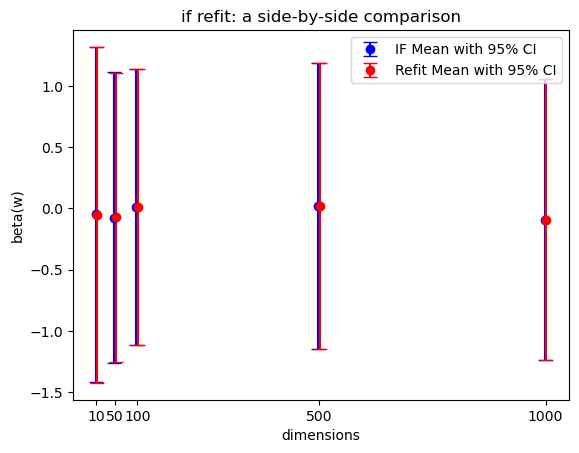

In [58]:
# create a plot for experiment 1.
experiment_1_data = pd.DataFrame(experiment_1_df[1:])

# Extracting p, mean, and standard deviation
dimensions = np.array(experiment_1_data['p'])
if_means = np.array(experiment_1_data['if_mean'])
if_sds = np.array(experiment_1_data['if_sd'])
refit_means = np.array(experiment_1_data['refit_mean'])
refit_sds = np.array(experiment_1_data['refit_sd'])

# Calculating confidence intervals (95% CI)
if_ci_lower = [mean - 1.96 * sd for mean, sd in zip(if_means, if_sds)]
if_ci_upper = [mean + 1.96 * sd for mean, sd in zip(if_means, if_sds)]
refit_ci_lower = [mean - 1.96 * sd for mean, sd in zip(refit_means, refit_sds)]
refit_ci_upper = [mean + 1.96 * sd for mean, sd in zip(refit_means, refit_sds)]

# Create offsets for side-by-side positioning
offset = 2.0
x_pos1 = dimensions - offset
x_pos2 = dimensions + offset

# Plotting
plt.errorbar(x_pos1, if_means, 
             yerr=[if_means - if_ci_lower, if_ci_upper - if_means], 
             fmt='o', capsize=5, label='IF Mean with 95% CI', color='blue')
plt.errorbar(x_pos2, refit_means, 
             yerr=[refit_means - refit_ci_lower, refit_ci_upper - refit_means], 
             fmt='o', capsize=5, label='Refit Mean with 95% CI', color='red')

# Labels and legend
plt.xticks(dimensions)
plt.xlabel('dimensions')
plt.ylabel('beta(w)')
plt.title('if refit: a side-by-side comparison')
plt.legend()
# plt.savefig('plota.1.pdf')
# plt.savefig('plotc.1.pdf')
plt.show()

In [59]:
experiment_1_data

,p,if_mean,if_sd,refit_mean,refit_sd,diff_mean,diff_sd,log_diff_mean,log_diff_sd
1,10,-0.049283,0.696911,-0.053291,0.699225,0.033989,0.041983,-4.088261,1.304538
2,50,-0.074369,0.604085,-0.073406,0.602841,0.005694,0.008041,-5.984553,1.565023
3,100,0.012938,0.574420,0.013239,0.574011,0.003500,0.004153,-6.488693,1.556544
4,500,0.019140,0.596367,0.018876,0.596519,0.000712,0.000841,-7.893098,1.296431
5,1000,-0.091937,0.584283,-0.091895,0.584277,0.000319,0.000358,-8.860359,1.601684


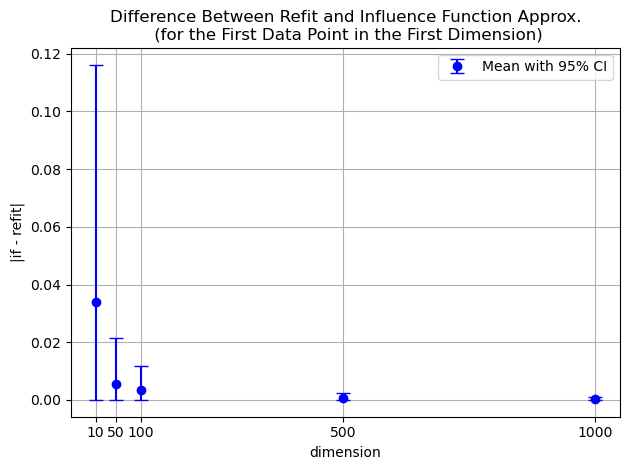

In [67]:
# create a plot for experiment 1.
experiment_1_data = pd.DataFrame(experiment_1_df[1:])

# Extracting p, mean, and standard deviation
dimension = np.array(experiment_1_data['p'])
diff_means = np.array(experiment_1_data['diff_mean'])
diff_sds = np.array(experiment_1_data['diff_sd'])
logdiff_means = np.array(experiment_1_data['log_diff_mean'])
logdiff_sds = np.array(experiment_1_data['log_diff_sd'])

# Calculating confidence intervals (95% CI)
ci_lower = [1.96 * sd for mean, sd in zip(diff_means, diff_sds)]
ci_upper = [1.96 * sd for mean, sd in zip(diff_means, diff_sds)]

# Calculate the error bars, ensuring the lower bound is not below zero
truncated_ci_lower = diff_means - ci_lower
for i in range(len(truncated_ci_lower)):
    if diff_means[i] - ci_lower[i] < 0:
        truncated_ci_lower[i] = diff_means[i]
# print("lower bounds: ", lower_bound)
# print("1.96sd: ", 1.96 * diff_sds)
# print("mean", diff_means)
# print('ci_upper:', ci_upper)

plt.errorbar(dimension, diff_means, yerr=[truncated_ci_lower, ci_upper], 
                 fmt='o', capsize=5, label='Mean with 95% CI', color='blue')

# labels
plt.title('Difference Between Refit and Influence Function Approx.\n (for the First Data Point in the First Dimension)')
plt.xlabel('dimension')
plt.ylabel('|if - refit|')
plt.xticks(dimension)  # Set x-ticks to dimension.
plt.grid(True)
plt.legend()
plt.tight_layout()
# Show plot
# plt.savefig('plota.2.pdf')
# plt.savefig('plotc.2.pdf')
plt.show()

In [62]:
# the |IF - refit| avg worst case error across data points and dimensions.
# average |IF - refit| across all simulations. pick out the worst case.
experiment_2 = []
for p in range(len(P_LIST)):
    diff_mean = np.mean([np.abs(ALL_SIMS[p]['results'][sim_num]['if'] -  ALL_SIMS[p]['results'][sim_num]['refit']) for sim_num in range(N_SIM)], axis=0) # computes the mean IF-Refit matrix (NxP).

    max_diff_mean = np.max(diff_mean)
    # find the index of the maximum difference.
    max_diff_index = np.argmax(diff_mean)
    max_index_2d = np.unravel_index(max_diff_index, diff_mean.shape)

    diff_sd = np.std([np.abs(ALL_SIMS[p]['results'][sim_num]['if'] - ALL_SIMS[p]['results'][sim_num]['refit']) for sim_num in range(N_SIM)], axis=0)
    max_diff_sd = diff_sd[max_index_2d[0]][max_index_2d[1]]

    p_curr = {'p': P_LIST[p], 'max_diff_mean': max_diff_mean, 'max_diff_sd': max_diff_sd}
    experiment_2.append(p_curr)
    
experiment_2_df = pd.DataFrame(experiment_2)
print(experiment_2_df)

      p  max_diff_mean  max_diff_sd
0     1       2.655965     7.405257
1    10       0.056004     0.096211
2    50       0.009985     0.012351
3   100       0.005357     0.006472
4   500       0.001084     0.001233
5  1000       0.000685     0.000668


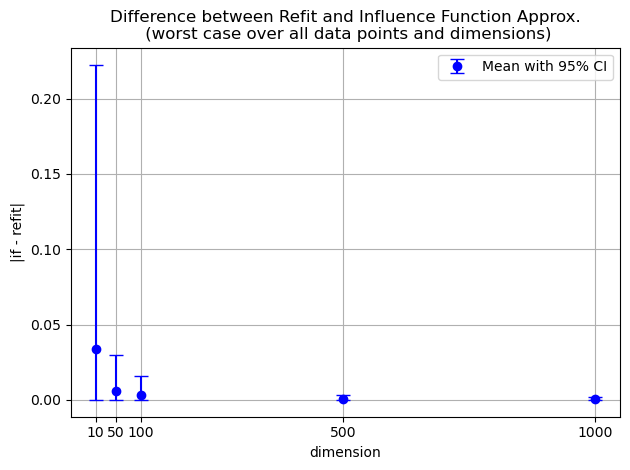

In [66]:
# create a plot for experiment 2.
experiment_2_data = pd.DataFrame(experiment_2_df[1:])

# Extracting p, mean, and standard deviation
dimension = np.array(experiment_2_data['p'])
max_diff_means = np.array(experiment_2_data['max_diff_mean'])
max_diff_sds = np.array(experiment_2_data['max_diff_sd'])

# Calculating confidence intervals (95% CI)
ci_lower = [1.96 * sd for mean, sd in zip(max_diff_means, max_diff_sds)]
ci_upper = [1.96 * sd for mean, sd in zip(max_diff_means, max_diff_sds)]

# Calculate the error bars, ensuring the lower bound is not below zero
truncated_ci_lower = diff_means - ci_lower
for i in range(len(truncated_ci_lower)):
    if diff_means[i] - ci_lower[i] < 0:
        truncated_ci_lower[i] = diff_means[i]

plt.errorbar(dimension, diff_means, yerr=[truncated_ci_lower, ci_upper], 
                 fmt='o', capsize=5, label='Mean with 95% CI', color='blue')

# Adding titles and labels
plt.title('Difference between Refit and Influence Function Approx.\n (worst case over all data points and dimensions)')
plt.xlabel('dimension')
plt.ylabel('|if - refit|')
plt.xticks(dimension)  # Set x-ticks to dimension.
plt.grid(True)
plt.legend()
plt.tight_layout()

# plt.savefig('plotb.2.pdf')
# Show plot
plt.show()

In [65]:
# experiment_1_df.to_csv('experiment_1_oct24.csv', index=False)
# experiment_2_df.to_csv('experiment_2_oct24.csv', index=False)